In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import keras
from models import model_v2
from tensor_dlt import TensorDLT
from spatial_transformer import spatial_transformer_network

2024-02-28 19:40:05.691371: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-28 19:40:05.719848: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 19:40:05.719872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 19:40:05.720526: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-28 19:40:05.725538: I tensorflow/core/platform/cpu_feature_guar

In [3]:
# dataset
from pathlib import Path
from DataGenerator import DataGenerator

batch_size=8
def config_ds(ds):
    AUTOTUNE = tf.data.AUTOTUNE
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    ds = ds.batch(batch_size)
    return ds

# training set data generator
root = "/home/ji/Dropbox/Robotics/CMSC733/Project1"
train_path = Path(root) / "Phase2" / "Data" / "Train_Resize"
val_path = Path(root) / "Phase2" / "Data" / "Val_Resize"

rho=32
train_gen = DataGenerator(train_path,
                          mode="unsupervised_with_h4pt",
                          rho=rho,
                          crop_size=128)
val_gen = DataGenerator(val_path,
                          mode="unsupervised_with_h4pt",
                          rho=rho,
                          crop_size=128)


# tensorflow dataset
im_crop_shape = (train_gen.crop_size,train_gen.crop_size,3)
im_ori_shape = (train_gen.resize_shape[1],train_gen.resize_shape[0],3)

output_signature=(  #input
                    (tf.TensorSpec(shape=im_crop_shape,dtype=tf.float32),
                    tf.TensorSpec(shape=im_crop_shape,dtype=tf.float32),
                    tf.TensorSpec(shape=im_ori_shape,dtype=tf.float32),
                    tf.TensorSpec(shape=(2,),dtype=tf.float32),
                    ),
                     # output
                    (tf.TensorSpec(shape=im_ori_shape,dtype=tf.float32), 
                     tf.TensorSpec(shape=(8,),dtype=tf.float32))
                    )
train_ds = tf.data.Dataset.from_generator(train_gen,
                                          output_signature=output_signature)
val_ds = tf.data.Dataset.from_generator(val_gen,
                                          output_signature=output_signature)

train_ds = config_ds(train_ds)
val_ds = config_ds(val_ds)

sample_input, sample_output = next(iter(train_ds))
print("input shapes:")
for i in sample_input:
    print(i.shape)
print("output shape")
for i in sample_output:
    print(i.shape)

2024-02-28 19:40:07.311242: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-28 19:40:07.344605: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-28 19:40:07.351486: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

reshuffling dataset
input shapes:
(8, 128, 128, 3)
(8, 128, 128, 3)
(8, 240, 320, 3)
(8, 2)
output shape
(8, 240, 320, 3)
(8, 8)


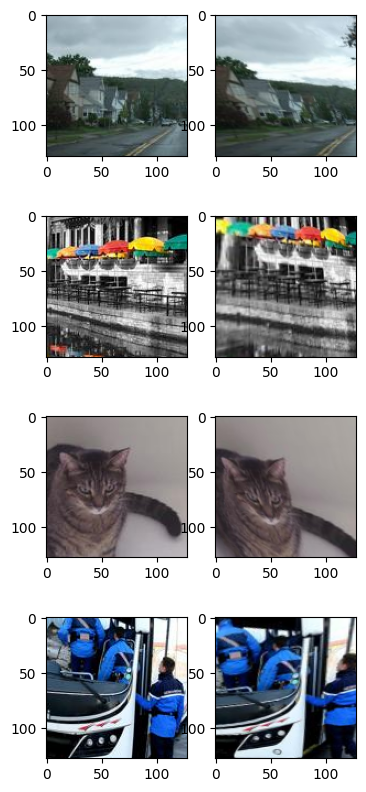

In [4]:
# plot some samples
import matplotlib.pyplot as plt
sample_input, sample_output = next(iter(train_ds))

plt.figure(figsize=(4,10))
for i in range(4):
    plt.subplot(4,2,2*i+1)
    plt.imshow(tf.squeeze(sample_input[0][i,:,:,:])/255.)
    plt.subplot(4,2,2*i+2)
    plt.imshow(tf.squeeze(sample_input[1][i,:,:,:])/255.)
plt.show()

In [5]:
# build new model with TensorDLT and STN added
homography_net = model_v2()
homography_net.load_weights('./chkpt_weight/checkpoint_mdl_v2_rho32')

# retrieve the input of the network
cropped_img1 = keras.layers.Input(shape=im_crop_shape)
cropped_img2 = keras.layers.Input(shape=im_crop_shape)
img_ori = keras.layers.Input(shape=im_ori_shape)

h4pt_batch = homography_net([cropped_img1,cropped_img2]) # batch by 8
h4pt_batch = tf.clip_by_value(h4pt_batch,clip_value_min=-rho,clip_value_max=rho)

upper_left_corner = keras.layers.Input(shape=(2,)) # batch by 2

# feed the homography net output to the TensorDLT to recover actual homography
homography = TensorDLT(h4pt_batch=h4pt_batch,
                       upper_left_corner=upper_left_corner,
                       batch_size=batch_size)

# use spatial transformer to get predicted image
img_pred = spatial_transformer_network(img_ori,
                                       homography,
                                       img_height=im_ori_shape[0],
                                       img_width=im_ori_shape[1],
                                       )

full_model = keras.Model(inputs=[cropped_img1,
                                 cropped_img2,
                                 img_ori,
                                 upper_left_corner,
                                 ], 
                        outputs=[img_pred,h4pt_batch])

# rename output layers
full_model.layers[2]._name = 'h4pt_output'
full_model.layers[-1]._name = 'img_output'

full_model.summary()


2024-02-28 19:40:09.721881: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-28 19:40:10.115975: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x8b6dae0


KerasTensor(type_spec=TensorSpec(shape=(8, 3, 3), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'tf.cast'")
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 h4pt_output (Functional)    (None, 8)                    3777980   ['input_4[0][0]',             
                                                          0          'input_5[0][0]']             
                                               

2024-02-28 19:40:11.092944: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-28 19:40:11.169508: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[[  3. -32.  -1.  11.  -7.  26.  27. -31.]
 [-29.  11.  25.   8.   4.  27.   1.  -1.]
 [  4. -19. -12.  31.  28.  14.   5.  -9.]
 [ 19. -26.  -8.   1. -24.  10.  -7.  15.]
 [ 24. -24. -30.  11. -28.  -7. -10.  21.]
 [ 10.  14.  14.   2. -24. -30. -17.  -1.]
 [ 10.  11.  30.  15.   9.  15. -26. -32.]
 [  1. -12. -28.   7.  16. -19. -13.  15.]], shape=(8, 8), dtype=float32)
tf.Tensor(
[[ -1. -32.  -2.  13.  -7.  26.  28. -32.]
 [-25.  20.  26.  21.   6.  28.   0.  -4.]
 [  1. -18.  -6.  28.  24.  12.   7. -12.]
 [ 16. -25.  -6.  -3. -24.  12.  -7.  15.]
 [ 25. -22. -31.   8. -29. -10. -11.  22.]
 [ 13.  15.  16.  -1. -19. -22. -20.   0.]
 [  8.  11.  28.   9.  12.  17. -28. -22.]
 [  2. -15. -29.  11.  16. -17. -16.  16.]], shape=(8, 8), dtype=float32)


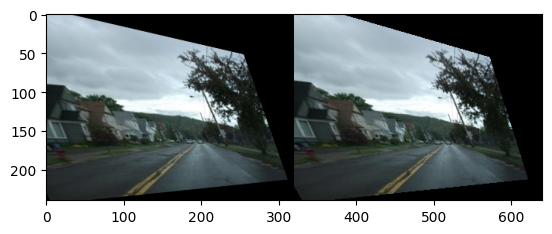

In [6]:
import numpy as np
# try calling the full model with sample input
sample_model_output = full_model(sample_input)
assert(sample_model_output[0].shape==sample_input[2].shape)
print(sample_output[-1])
print(tf.round(sample_model_output[1]))

import matplotlib.pyplot as plt
plt.imshow(np.hstack( ((sample_output[0][0,:,:,:]).numpy(),
                      (sample_model_output[0][0,:,:,:]).numpy())
            )
           )


In [7]:
# define loss and metrics
def loss_img(y_true, y_pred):
    # y_true and y_pred are now batch of images
    return tf.reduce_mean(tf.abs(y_true-y_pred)) # notice 1-norm is used


def metric_abs(y_true, y_pred):
    """computes the mean difference between predicted and actual corner shift
    values in x and y direction

    Args:
        y_true (_type_): _description_
        y_pred (_type_): _description_

    Returns:
        _type_: _description_
    """
    return tf.reduce_mean(tf.abs(y_true-y_pred))

def metric_dist(y_true, y_pred):
    """compute the l2 distance between corner

    Args:
        y_true (_type_): _description_
        y_pred (_type_): _description_
    """
    d = tf.reshape(y_true,(-1,4,2))-tf.reshape(y_pred,(-1,4,2))
    return tf.reduce_mean(tf.norm(d,ord='euclidean',axis=-1))

# compile model
full_model.compile( optimizer=keras.optimizers.Adam(learning_rate=1e-5,
                                                    clipvalue=0.5),
                    loss=loss_img,
                    loss_weights = [1.0,0.0], # use only image loss
                    metrics=[[loss_img,],
                            [metric_abs,metric_dist]])

In [8]:
import numpy as np
steps_per_epoch = int(np.floor(5000/batch_size))
# start training
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                factor=0.2,
                                                patience=5,
                                                min_lr=1e-6,
                                                verbose=1,
                                                cooldown=5)

# save check points
checkpoint_filepath = './checkpoint_mdl_unsupervised'
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='loss',
    mode='min',
    save_freq = steps_per_epoch*10
    )

history = full_model.fit(train_ds,
                         epochs=100,
                         steps_per_epoch=steps_per_epoch,
                         validation_data=val_ds,
                         validation_steps=int(np.floor(1000/batch_size)),
                         validation_freq=1,
                         verbose=True,
                         callbacks=[reduce_lr, checkpoint_callback])

Epoch 1/100


2024-02-28 19:40:25.106689: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fea15482800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-28 19:40:25.106714: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-02-28 19:40:25.110187: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709167225.165252  264381 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 [==============================] - ETA: 0s - loss: 0.1213 - tf.math.add_n_loss: 0.1213 - tf.clip_by_value_loss: 6.4117 - tf.math.add_n_loss_img: 0.1213 - tf.clip_by_value_metric_abs: 6.4117 - tf.clip_by_value_metric_dist: 10.1131reshuffling dataset
reshuffling dataset
625/625 [==============================] - 79s 104ms/step - loss: 0.1213 - tf.math.add_n_loss: 0.1213 - tf.clip_by_value_loss: 6.4117 - tf.math.add_n_loss_img: 0.1213 - tf.clip_by_value_metric_abs: 6.4117 - tf.clip_by_value_metric_dist: 10.1131 - val_loss: 0.0828 - val_tf.math.add_n_loss: 0.0828 - val_tf.clip_by_value_loss: 2.9839 - val_tf.math.add_n_loss_img: 0.0828 - val_tf.clip_by_value_metric_abs: 2.9839 - val_tf.clip_by_value_metric_dist: 4.6801 - lr: 1.0000e-05
Epoch 2/100
625/625 [==============================] - 64s 102ms/step - loss: 0.1229 - tf.math.add_n_loss: 0.1229 - tf.clip_by_value_loss: 6.5362 - tf.math.add_n_loss_img: 0.1229 - tf.clip_by_value_metric_abs: 6.5362 - tf.clip_by_value_metric_dist: 10

InvalidArgumentError: Graph execution error:

Detected at node model_2/tf.linalg.inv_1/MatrixInverse defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 542, in dispatch_queue

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 531, in process_one

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 775, in execute_request

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_264163/4211711445.py", line 21, in <module>

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/layers/core/tf_op_layer.py", line 242, in _call_wrapper

  File "/home/ji/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/layers/core/tf_op_layer.py", line 279, in _call_wrapper

Input is not invertible.
	 [[{{node model_2/tf.linalg.inv_1/MatrixInverse}}]] [Op:__inference_train_function_20674]

In [19]:
import numpy as np
ind = np.array([0,1,2,3])
a = np.random.randn(4,2)
a

array([[-2.0245613 ,  0.0795189 ],
       [ 1.59863843,  1.00238566],
       [-0.32244695, -1.69606482],
       [-0.68382129,  0.39075812]])

In [21]:
a[(ind+1)%4,:]

array([[ 1.59863843,  1.00238566],
       [-0.32244695, -1.69606482],
       [-0.68382129,  0.39075812],
       [-2.0245613 ,  0.0795189 ]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


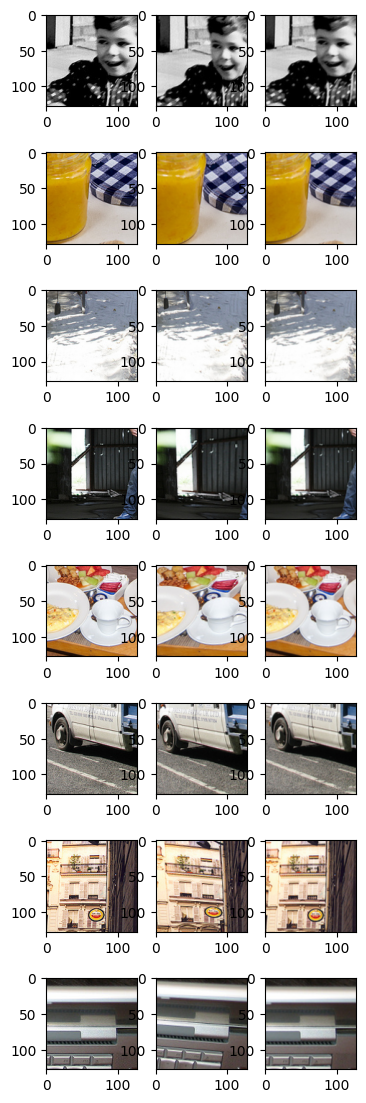

In [71]:
# see how the model is doing
sample_model_output = full_model(sample_input)
plt.figure(figsize=(4,14))
for i in range(8):
    plt.subplot(8,3,3*i+1)
    plt.imshow(tf.squeeze(sample_input[0][i,:,:,:])/255.)
    plt.subplot(8,3,3*i+2)
    plt.imshow(tf.squeeze(sample_input[1][i,:,:,:])/255.)
    plt.subplot(8,3,3*i+3)
    plt.imshow(tf.squeeze(sample_model_output[i,:,:,:])/255.)
plt.show()